<a href="https://colab.research.google.com/github/avkornaev/Python-for-image-processing-course/blob/main/Cells_counter_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary
The cells counter algorithm is based on watershed method. If you want to know more, please check the following links: https://imagej.net/plugins/classic-watershed,
https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

**Install libraries**.

Execute code bellow just once to install the libraries. Then you may comment 'pip' lines using # in the begining of lines of the code.

In [1]:
!pip install -Uqq fastbook
!pip install czifile
!pip install tifffile
!pip install imagecodecs

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 188 kB 43.8 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 224 kB/s 
     |████████████████████████████████| 29.6 MB 24 kB/s 


**Connect to Google disk.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries.**

In [3]:
import fastbook
from fastbook import *
import cv2
import numpy as np
#from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import measure, color, io, img_as_ubyte, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.segmentation import clear_border, join_segmentations
import pandas as pd
import czifile
import imagecodecs
#import tifffile

**Check the settings.**

In [4]:
#Image under study
img_path = '/content/drive/MyDrive/Cells_count/'
img_title = 'B16_1122_2_2.czi' # 'B16_control 2_2.czi'
pixels2microns = 0.396 #scale factor (check the image properties in Zen or Apeer)

#Visualisation
img_size = [0,0,1024,1024] # empty [] or rectangle coordinates, e.g. [0,0,512,512]
fig_size = (30,30) # figures size
img_map  = 'Blues' # image map. For example, 'gray','hot','jet','Blues' et al. If you want to know more, please type the following code: help(plt.imshow)
img_map1 = 'jet'

#Filtering
kernel = np.ones((5,5),np.uint8)
kernel4filt = 5
ps = 5 # patch_size
patchDist = 3 # patch_distance
hc = 115 # coefficient

numberOfIter = 2 #number of iterations
dist_transf_ratio = 0.1 # distance transform ratio
dist_transf_param = 5
markers_bias = 100

clearBorder = 'off' # delete markers at the borders: 'on' or 'off'

**Download "czi" image and create slices of the image.**

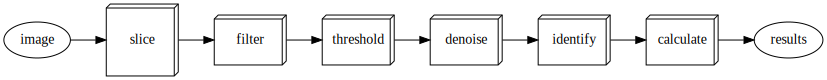

In [5]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=1] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [6]:
img = czifile.imread(img_path + img_title)

if img_size == []:
  img_size = [0,0,img.shape[5],img.shape[6]] # full size

img_slice = img[0,0,0,:,0,img_size[0]:img_size[2],img_size[1]:img_size[3],0]# image in a form of 3D matrix
img0 = img_slice[0,:,:] # 0 channel that is fluo4-T1 (highlights the apoptosed cells)
img1 = img_slice[1,:,:] # 1 channel that is H3342-T2 (highlights all the cells)
channels = [img0,img1] # channels of the image

nc = len(channels)
n = [i for i in range(nc)] # auxiliary variable 

print('CZI image shape: ',img.shape)# ?, ?, ?,number of chanels,x size,y size, ?
for i in n:
  print(i,'channel shape: ',channels[i].shape, channels[i].dtype, type(channels[i]))
  print(np.amax(channels[i]))
print('0 channel shape: ',img0.shape,img0.dtype,type(img0))
print(np.amax(img0))
print('1 channel shape: ',img1.shape,img1.dtype,type(img1))
print(np.amax(img1))

CZI image shape:  (1, 1, 1, 2, 1, 3277, 3277, 1)
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
64754
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
64754
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535


**Create templates (empty lists).**

In [7]:
channelsF = [0]*nc # filtered channels template
img_path_temp = [0]*nc # another one template
channelsFGray = [0]*nc # and another one
ret = [0]*nc # one more template
thresh = [0]*nc # one more template
opening = [0]*nc # one more template
sure_bg = [0]*nc # one more template
sure_fg = [0]*nc # one more template
ret1 = [0]*nc # one more template
dist_transform = [0]*nc # one more template
unknown = [0]*nc # one more template
ret2 = [0]*nc # one more template
markers = [0]*nc # one more template
markersi= [0]*nc # one more template
channelsFB = [0]*nc # one more template
channelsFW = [0]*nc # one more template
channelsFWi= [0]*nc # one more template
regions = [0]*nc
numberOfCells = [0]*nc

**Filter channel images.**

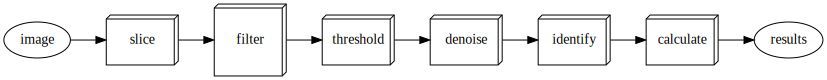

In [8]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=1] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')
# https://laptrinhx.com/five-lessons-from-my-data-science-internship-at-hara-1112784335/

In [9]:
for i in n:
  # "denoise_nl_means" performs non-local means denoising
  sigma_est = np.mean(estimate_sigma(channels[i], multichannel=False))
  patch_kw = dict(patch_size=ps, patch_distance=patchDist, multichannel=False)
  channelsF[i] = denoise_nl_means(channels[i], h=hc*sigma_est, fast_mode=False, **patch_kw)
  
  channelsF[i] = np.uint16(channelsF[i])

  # Apply a multidimensional median filter
  channelsF[i] = ndimage.median_filter(channelsF[i], size=kernel4filt)

  print(i,'channel sigma estimation = ',sigma_est)
  print(i,'channel shape: ',channelsF[i].shape, channelsF[i].dtype, type(channelsF[i]))
  print(np.amax(channelsF[i]))
   

0 channel sigma estimation =  3.1868817164581675
0 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
50940
1 channel sigma estimation =  236.18051028651746
1 channel shape:  (1024, 1024) uint16 <class 'numpy.ndarray'>
65535


**Visualize channels before and after filtering.**

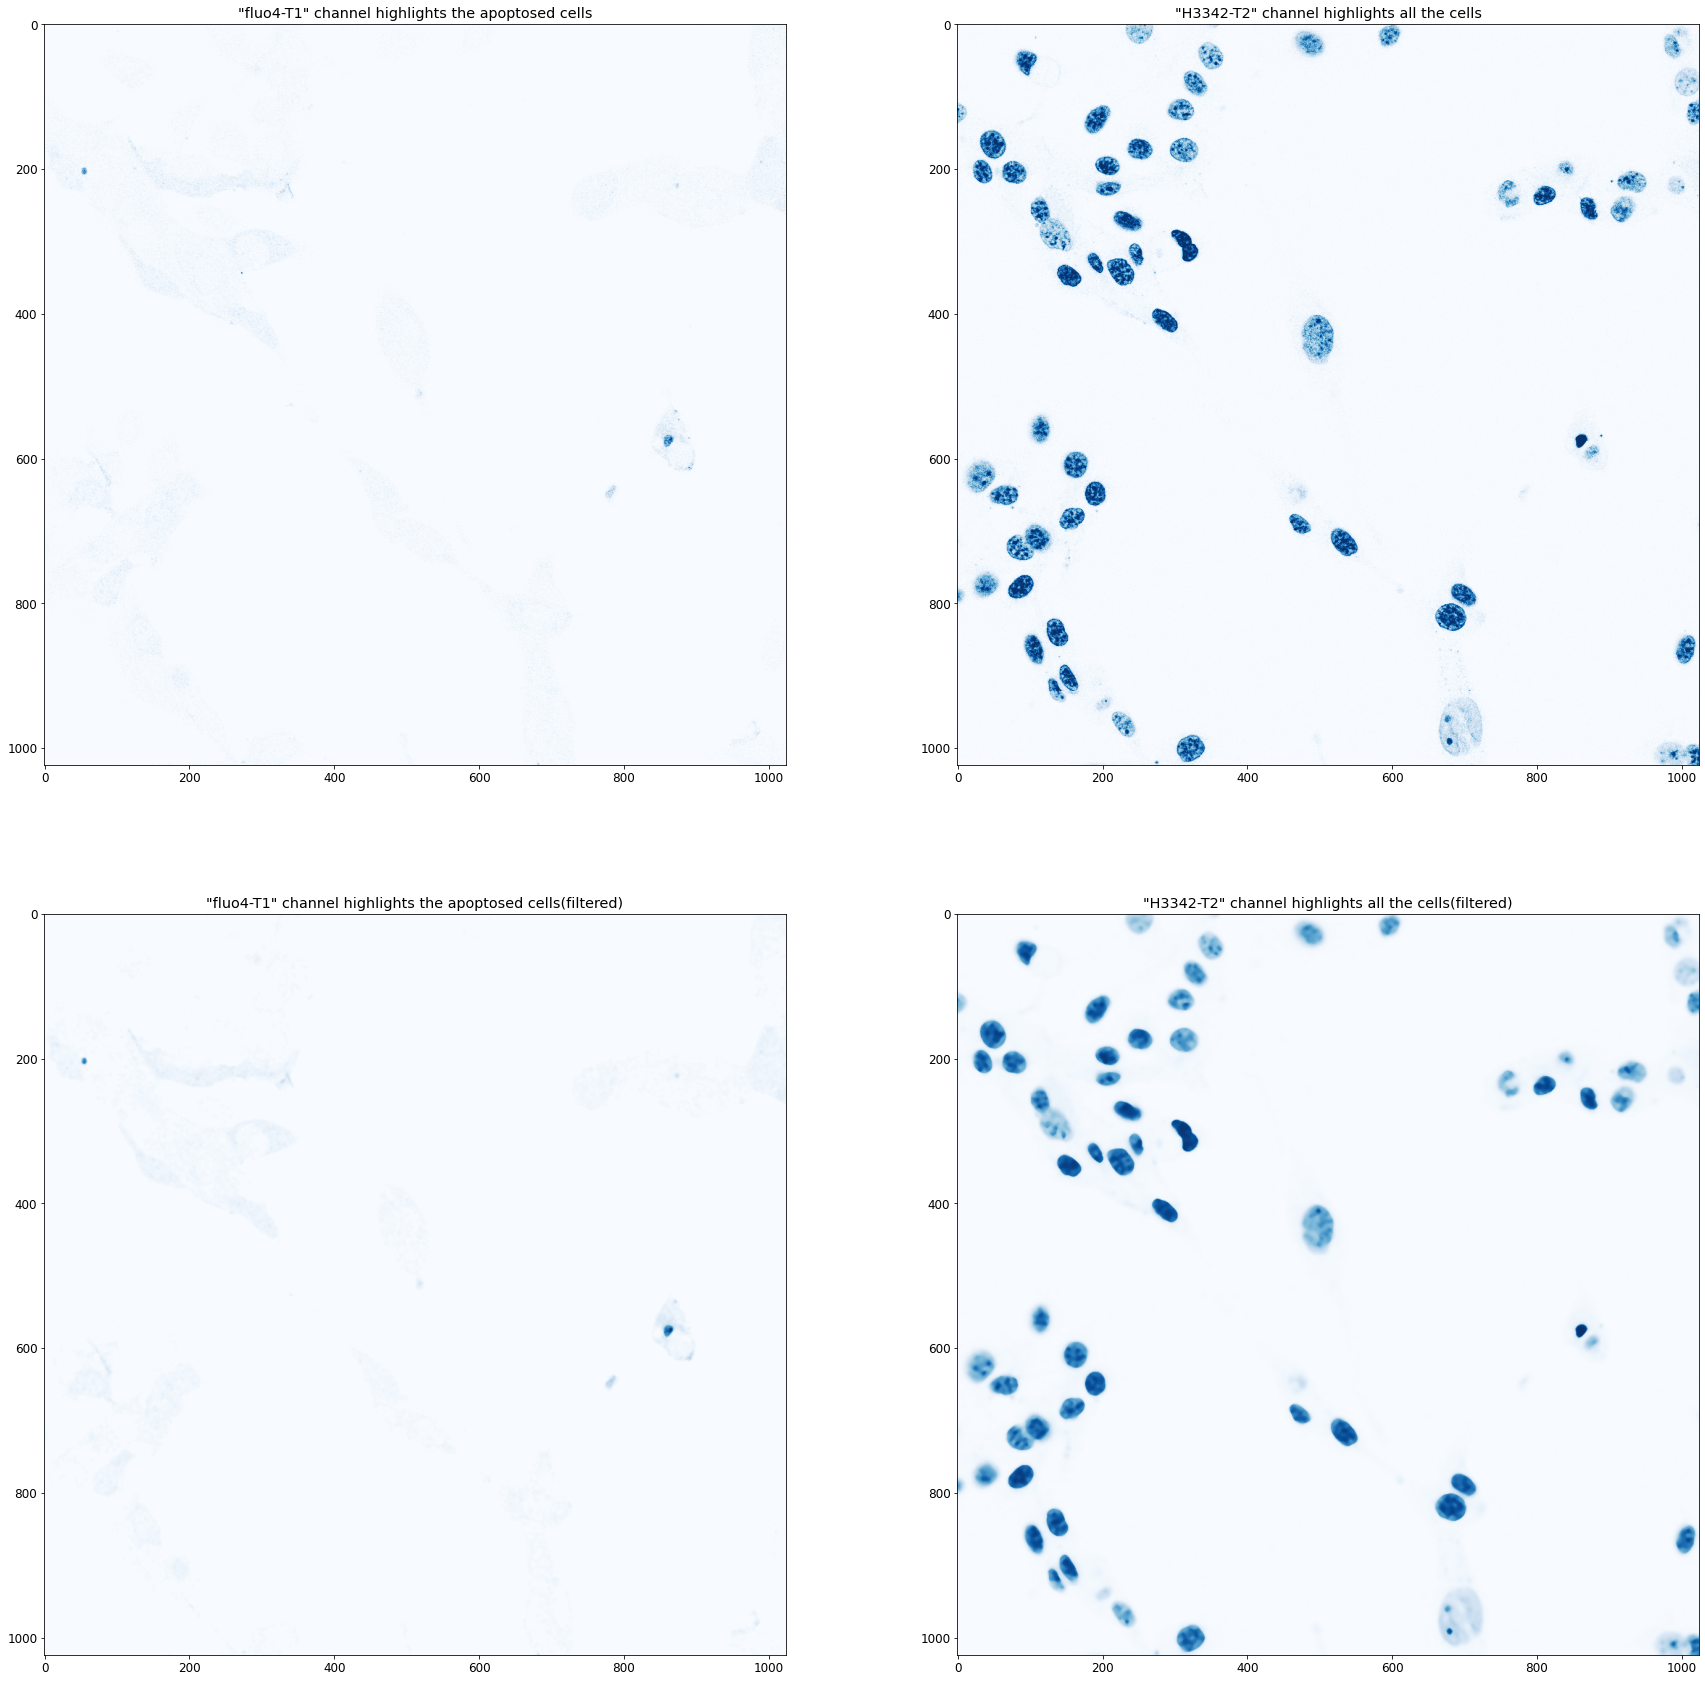

In [10]:
titles = ['"fluo4-T1" channel highlights the apoptosed cells',
          '"H3342-T2" channel highlights all the cells']
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channels[i],cmap=img_map)
  plt.title(titles[i])
  plt.subplot(2,2,i+3)
  plt.imshow(channelsF[i],cmap=img_map)
  plt.title(titles[i]+'(filtered)')  

In [11]:
#plt.figure(figsize=fig_size)
#plt.imshow(channelsF[1],cmap = img_map)

**Create tepmorary 'tiff' files.**

In [12]:
for i in n:
  img_path_temp[i] = img_path + img_title[0:-4] + '_ch' + str(i) + '.tiff' # path 0
  cv2.imwrite(img_path_temp[i], channelsF[i]) # save channels in a temporary tiff file
print(img_path_temp)

['/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch0.tiff', '/content/drive/MyDrive/Cells_count/B16_1122_2_2_ch1.tiff']


**Read images using OpenCV.**

In [13]:
for i in n:
  channelsFGray[i] = cv2.imread(img_path_temp[i],cv2.IMREAD_GRAYSCALE)
  print(type(channelsFGray[i]),channelsFGray[i].shape,channelsFGray[i].dtype)

<class 'numpy.ndarray'> (1024, 1024) uint8
<class 'numpy.ndarray'> (1024, 1024) uint8


**Threshold and delete noise.**

Threshold image to binary using 'OTSU'. All the thresholded pixels are set to 255. Then remove noise using 'opening' and remove edge touching with 'clear_border' function (optional).

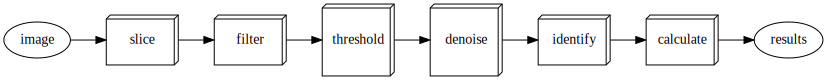

In [14]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=1] denoise[shape=box3d width=1 height=1] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [15]:
for i in n:
  ret[i], thresh[i] = cv2.threshold(channelsFGray[i], 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  opening[i] = cv2.morphologyEx(thresh[i],cv2.MORPH_OPEN,kernel,
                                iterations = numberOfIter)
  if clearBorder == 'on':
    opening[i] = clear_border(opening[i])

In [16]:
#cv2_imshow(channelsIntersection)
#cv2_imshow(openingi[0])
#cv2_imshow(opening[1])

**Identify background and foreground area (OpenCV - Distance Transformation). Apply watershed.**

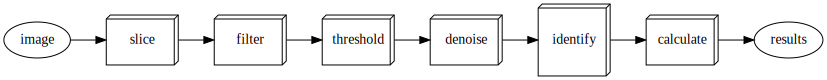

In [17]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=1] calculate[shape=box3d width=1 height=0.7]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [18]:
for i in n:
  sure_bg[i] = cv2.dilate(opening[i],
                          kernel,iterations=numberOfIter) # sure background
  dist_transform[i] = cv2.distanceTransform(opening[i],cv2.DIST_L2,
                                            dist_transf_param)
  
  ret1[i], sure_fg[i] = cv2.threshold(dist_transform[i],
                                      dist_transf_ratio*dist_transform[i].max(),
                                      255,0)
  sure_fg[i] = np.uint8(sure_fg[i]) # sure foreground
  
  unknown[i] = cv2.subtract(sure_bg[i], sure_fg[i])
  ret2[i], markers[i] = cv2.connectedComponents(sure_fg[i])
  markers[i] = markers[i] + markers_bias
  markers[i][unknown[i]==255] = 0

  markers[i] = cv2.watershed(cv2.imread(img_path_temp[i]),markers[i]) #The boundary regions will be marked as -1
  channelsFB[i] = cv2.imread(img_path_temp[i])
  channelsFB[i][markers[i] == -1] = [255,0,0]
  channelsFW[i] = color.label2rgb(markers[i], bg_label = 0)

In [19]:
print(thresh[0].shape, thresh[0].dtype,type(thresh[0]),np.max(thresh[0]))
print(opening[0].shape, opening[0].dtype,type(opening[0]),np.max(opening[0]))
print(dist_transform[0].shape, dist_transform[0].dtype,type(dist_transform[0]),np.max(dist_transform[0]))
print(sure_fg[0].shape, sure_fg[0].dtype,type(sure_fg[0]),np.max(sure_fg[0]))
print(markers[0].shape, markers[0].dtype,type(markers[0]),np.max(markers[0]))
print(channelsFB[0].shape, channelsFB[0].dtype,type(channelsFB[0]),np.max(channelsFB[0]))

(1024, 1024) uint8 <class 'numpy.ndarray'> 255
(1024, 1024) uint8 <class 'numpy.ndarray'> 255
(1024, 1024) float32 <class 'numpy.ndarray'> 6.0
(1024, 1024) uint8 <class 'numpy.ndarray'> 255
(1024, 1024) int32 <class 'numpy.ndarray'> 101
(1024, 1024, 3) uint8 <class 'numpy.ndarray'> 255


Visualize.

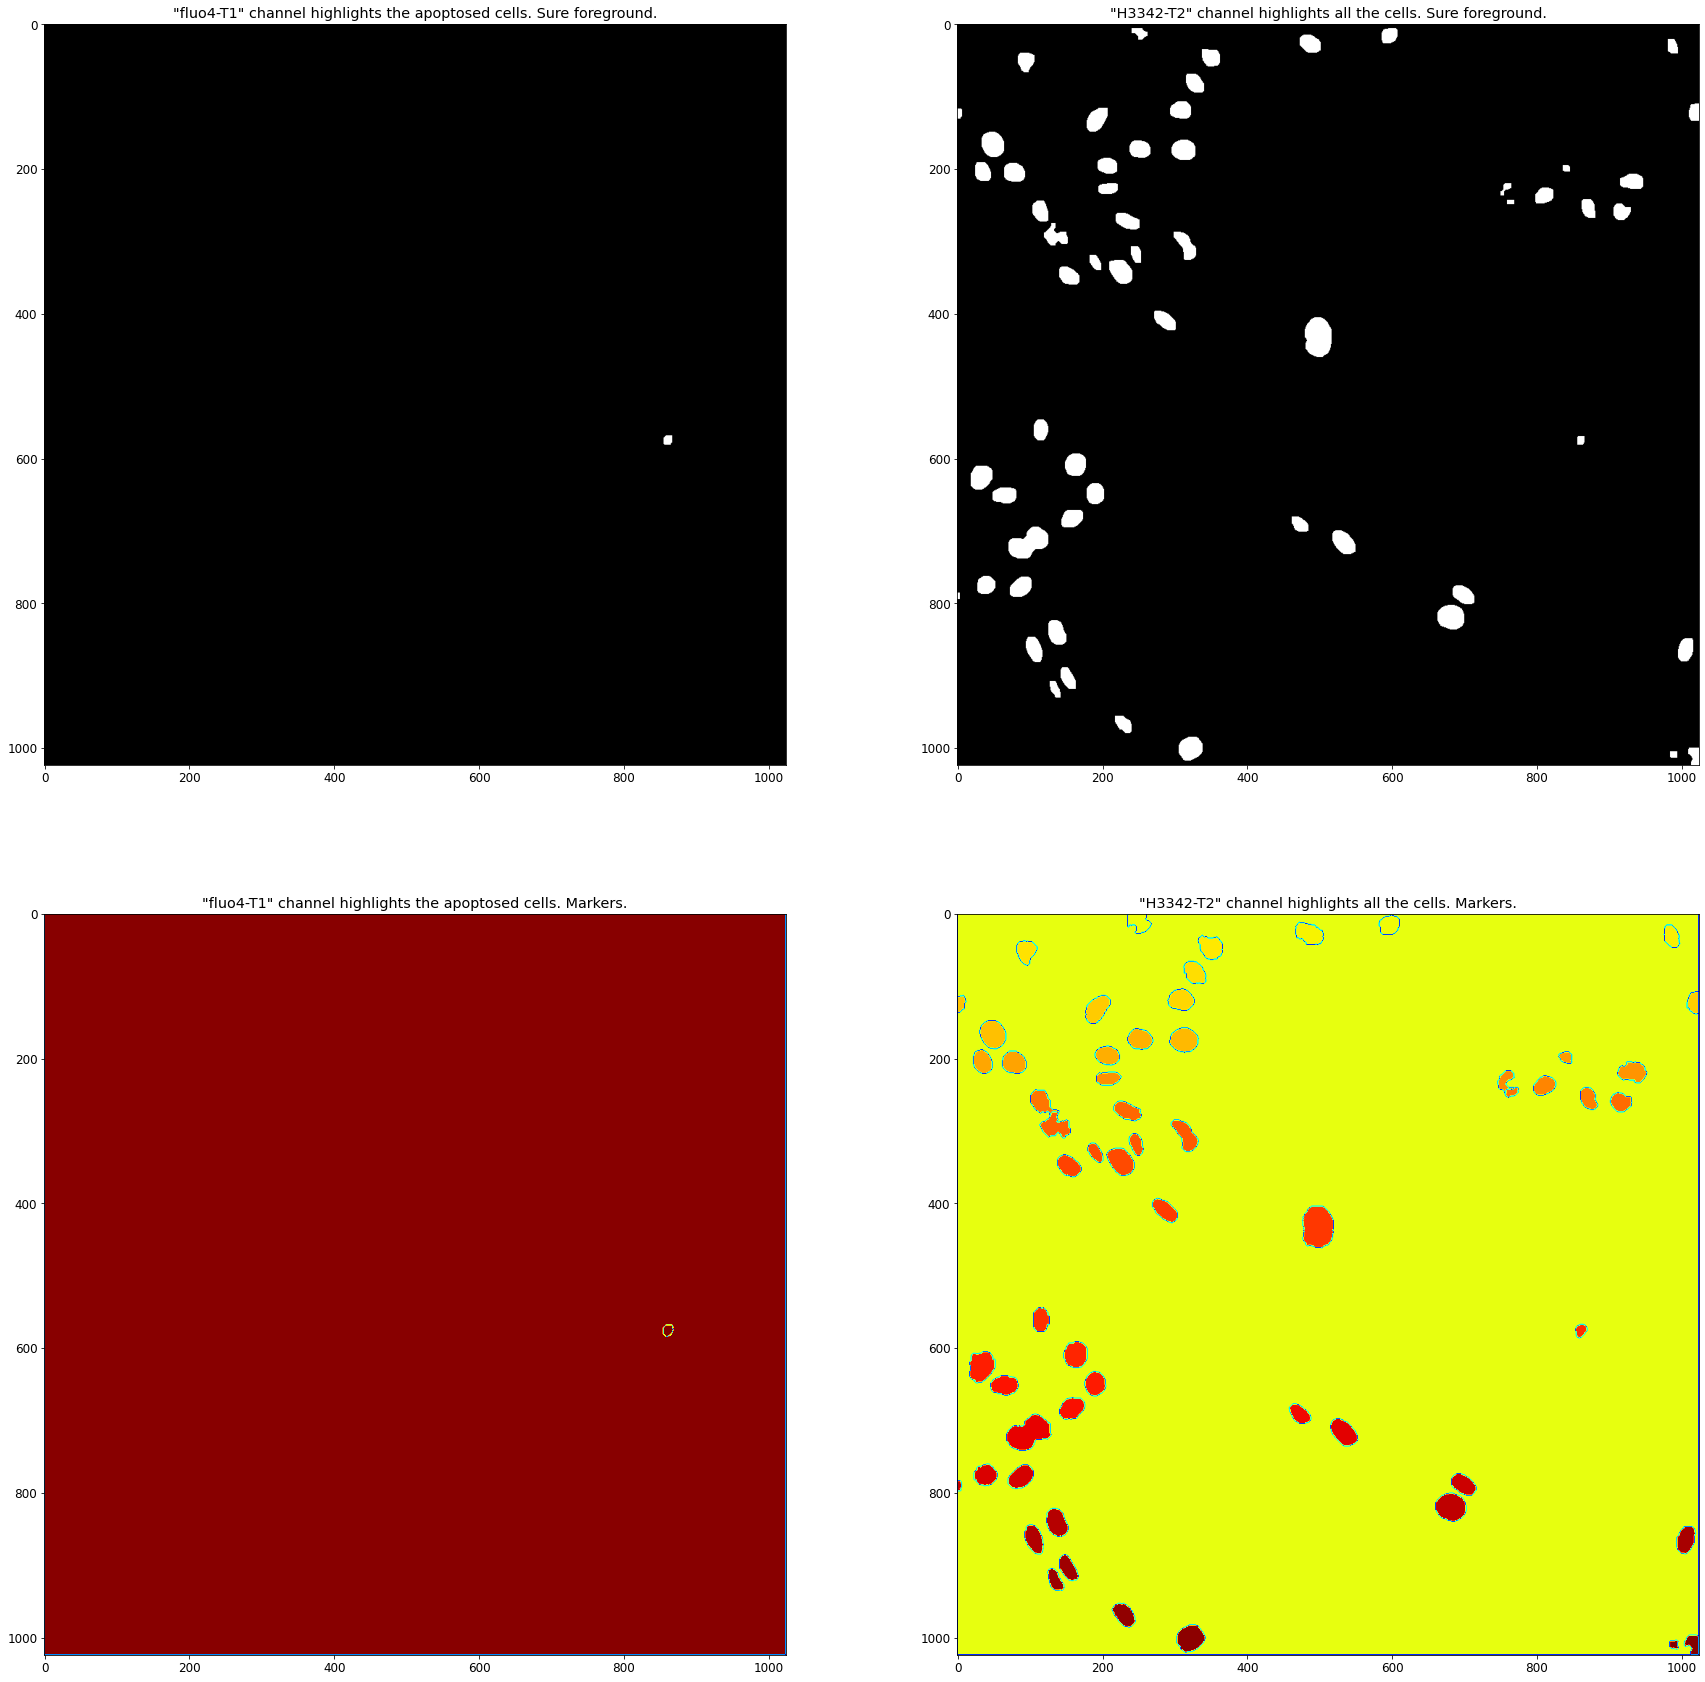

In [20]:
plt.figure(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(sure_fg[i],cmap='binary_r')
  plt.title(titles[i]+'. Sure foreground.')
  plt.subplot(2,2,i+3)
  plt.imshow(markers[i],cmap=img_map1)
  plt.title(titles[i]+ '. Markers.')

Compare channels intersections to find the apoptosed cells.

In [21]:
channelsFWIntersection = join_segmentations(channelsFW[0], channelsFW[1]) # intersection

channelsFWIGray = cv2.cvtColor(channelsFWIntersection, cv2.COLOR_BGR2GRAY)
#print(channelsFW2Gray.shape,channelsFW2Gray.dtype,type(channelsFW2Gray))
#print(np.max(channelsFGray))
reti, thresi = cv2.threshold(channelsFWIGray, 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)



#channelsFWi[0]=channelsIntersection/np.max(channelsIntersection) #intersection with normalization
#channelsFWi[1]=channelsFW[1]
#cv2_imshow(channelsFWi[0])

#channelsFW2Gray = cv2.cvtColor(channelsFW2, cv2.COLOR_BGR2GRAY)
#print(channelsFW2Gray.shape,channelsFW2Gray.dtype,type(channelsFW2Gray))
#print(np.max(channelsFGray))
#ret2, thres2 = cv2.threshold(channelsFW2Gray, 0, 255, 
#                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#color2 = label2rgb(channelsFW2, image=coins, image_alpha=0.5, bg_label=-1)
#cv2_imshow(thres2)

In [22]:
print(thresi.shape,thresi.dtype,type(thresi),np.max(thresi))

(1024, 1024) uint8 <class 'numpy.ndarray'> 255


In [23]:
img_path_tempi = img_path + img_title[0:-4] + '_chi' + str(i) + '.tiff' # path 0
cv2.imwrite(img_path_tempi, thresi) # save channels in a temporary tiff file

True

In [24]:
markersi[0] = thresi
#markersi[0] = cv2.watershed(cv2.imread(img_path_tempi),markersi[0]) #The boundary regions will be marked as -1
channelsFBi = cv2.imread(img_path_tempi)
channelsFBi[markersi[0] == -1] = [255,0,0]
#channelsFWi = color.label2rgb(markersi[0], bg_label = 0)

In [25]:
print(channelsFWIntersection.shape,channelsFWIntersection.dtype,type(channelsFWIntersection),np.max(channelsFWIntersection))
thresi = np.uint32(thresi)
print(thresi.shape,thresi.dtype,type(thresi),np.max(thresi))
#cv2_imshow(channelsFWIntersection)

(1024, 1024, 3) uint8 <class 'numpy.ndarray'> 3
(1024, 1024) uint32 <class 'numpy.ndarray'> 255


In [38]:
channelsFWIGray.dtype

dtype('uint8')

In [39]:
mark =np.uint32(channelsFWIGray)
mark = cv2.watershed(cv2.imread(img_path_tempi),mark) #The boundary regions will be marked as -1
cv2_imshow(markersi[0])

TypeError: ignored

In [30]:
imgg = cv2.imread(img_path_tempi)
imgg.dtype

dtype('uint8')

In [34]:
mark =np.uint32(markersi[0])
mark.dtype

dtype('uint32')

In [27]:
?cv2.watershed

In [ ]:
regionsi = measure.regionprops(markersi[0], intensity_image=channels[0])


In [ ]:
len(regionsi)-1

In [ ]:
print(markersi[0].shape, markersi[0].dtype,type(markersi[0]),np.max(markersi[0]))

In [ ]:
cv2_imshow(markersi[0]-markers_bias)

In [ ]:
print(channelsFWIntersection.shape, channelsFWIntersection.dtype,type(channelsFWIntersection),np.max(channelsFWIntersection))
bb=channelsFWi[0]
print(bb.shape, bb.dtype,type(bb),np.max(bb))

In [ ]:
#channelsFWi = join_segmentations(channelsFW[0], channelsFW[1]) # intersection
#channelsFWiGray = cv2.cvtColor(channelsFWi, cv2.COLOR_BGR2GRAY)
#reti, thresi = cv2.threshold(channelsFWiGray, 0, 255, 
#                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#markers[0] = np.int32(thresi)#cv2.watershed(cv2.imread(img_path_temp[0]),np.int32(thres2)) 

#channelsFB[0] = cv2.imread(img_path_temp[0])
#channelsFB[0][markers[0] == -1] = [255,0,0]
#channelsFW[0] = color.label2rgb(markers[0], bg_label = 0)
#cv2_imshow(thresi)

In [ ]:
#bb=markers[0]
#print(bb.shape, bb.dtype,type(bb),np.max(bb))
#print(np.max(markers[1]))
#print(np.max(thres2))


In [ ]:
#cv2_imshow(markers[0])

**Calculate metrics.**

https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [ ]:
#flow chart visualisation
gv('''slice[shape=box3d width=1 height=0.7] filter[shape=box3d width=1 height=0.7] threshold[shape=box3d width=1 height=0.7] denoise[shape=box3d width=1 height=0.7] identify[shape=box3d width=1 height=0.7] calculate[shape=box3d width=1 height=1]
image->slice->filter->threshold->denoise->identify->calculate->results''')

In [ ]:
for i in n:
  regions[i] = measure.regionprops(markers[i], intensity_image=channels[i])
  numberOfCells[i] = len(regions[i])-1
  #print(regions[i])
print('Numbers of cells in channel images are equal to',numberOfCells)

**Visualise and save metrics data.**

In [ ]:
d = [0]*nc
df_temp = [0]*nc

for i in n:
  nr = [i for i in range(len(regions[i]))]
  d[i] = pd.DataFrame()
  for j in nr:
    df_temp[i] = pd.DataFrame({'No':j, 
                          'Area (mum^2)':int(regions[i][j].area*(pixels2microns**2)),
                          'Equiv.diam. (mum)': regions[i][j].equivalent_diameter*pixels2microns,
                          'Major axis length (mum)':regions[i][j].major_axis_length*pixels2microns,
                          'Minor axis length (mum)':regions[i][j].minor_axis_length*pixels2microns,
                          'Mean intensity':regions[i][j].mean_intensity,
                          'Euler number': regions[i][j].euler_number,
                          'Centroid':[regions[i][j].centroid],
                          'Bounding box':[regions[i][j].bbox]})
    d[i] = pd.concat([d[i],df_temp[i]])
    d[i].to_csv(img_path + img_title[0:-4] +'_channel_'+str(i) + '.csv')  

In [ ]:
#Channel 0 ("fluo4-T1").
d[0]

In [ ]:
#Channel 1 ("H3342-T2").
d[1]

**Visualize boundaries and cells.**

In [ ]:
fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))
for i in n:
  plt.subplot(2,2,i+1)
  plt.imshow(channelsFB[i],cmap=img_map)
  plt.title(titles[i]+'. Detected boundaries.')
  plt.subplot(2,2,i+3)
  plt.imshow(channelsFW[i],cmap=img_map1)
  plt.title(titles[i]+ '. ' + str(numberOfCells[i]) + ' cells were detected')

In [ ]:
channelsFW2 = join_segmentations(channelsFW[0], channelsFW[1])
print(channelsFW2.shape,channelsFW2.dtype,type(channelsFW2))
channelsFW2Gray = cv2.cvtColor(channelsFW2, cv2.COLOR_BGR2GRAY)
print(channelsFW2Gray.shape,channelsFW2Gray.dtype,type(channelsFW2Gray))
print(np.max(channelsFGray))
ret2, thres2 = cv2.threshold(channelsFW2Gray, 0, 255, 
                                    cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#color2 = label2rgb(channelsFW2, image=coins, image_alpha=0.5, bg_label=-1)
cv2_imshow(thres2)

In [ ]:
print(np.max(channelsFW2))
print(np.max(channelsFW[1]))

#plt.figure(figsize=(fig_size[0],fig_size[1]))
#plt.imshow(channelsFW2,cmap=img_map1)

In [ ]:
bb=thres2
print(bb.shape, bb.dtype,type(bb))